# 1. Dataset Preparation and Preprocessing



In [1]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt

C:\Users\swast\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\swast\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def load_images_from_directory(directory, image_size= (32, 32)):
    images = []
    for label in os.listdir(directory):
        class_folder =os.path.join(directory, label)
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            img = Image.open(file_path).convert('L')
            img = img.resize(image_size)
            images.append(np.array(img))
    return np.array(images)
test_dir = r"C:\Users\swast\Downloads\Copy of devnagari digit\DevanagariHandwrittenDigitDataset\Test"
train_dir = r"C:\Users\swast\Downloads\Copy of devnagari digit\DevanagariHandwrittenDigitDataset\Train"

# Normalizing the image

In [4]:
x_train = load_images_from_directory(train_dir)
x_test = load_images_from_directory(test_dir)

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape for Keras: (samples, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Optional: Split a validation set from train
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)


# Adding Noise

In [5]:
def add_gaussian_noise(images, mean=0.0, std=0.5):
    noisy = images + np.random.normal(mean, std, images.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_gaussian_noise(x_train)
x_val_noisy = add_gaussian_noise(x_val)

# 2. Build the Denoising Convolutional Autoencoder:

In [6]:
input_img = Input(shape=(32, 32, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

# 3. Train the Denoising Autoencoder:

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.4710 - val_loss: 0.2098
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.2004 - val_loss: 0.1843
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.1815 - val_loss: 0.1795
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1751 - val_loss: 0.1710
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1706 - val_loss: 0.1688
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1680 - val_loss: 0.1667
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.1660 - val_loss: 0.1643
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1641 - val_loss: 0.1627
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.1631 - val_loss: 0.1632
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1619 - val_loss: 0.1609
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.1606 - val_loss: 0.1599
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━

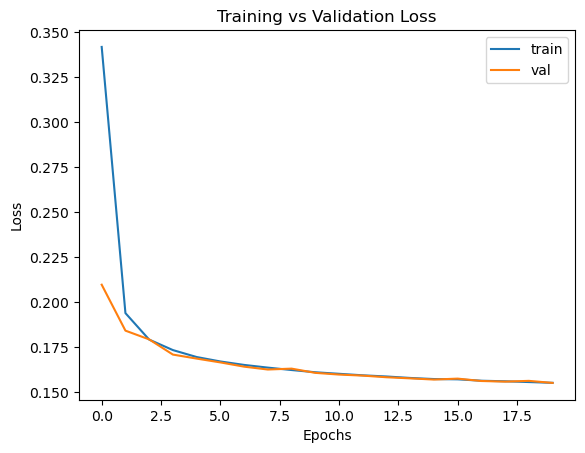

In [7]:

import matplotlib.pyplot as plt
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val_noisy, x_val)
)

# Plot loss curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


# 4. Evaluate and Visualize the Results

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


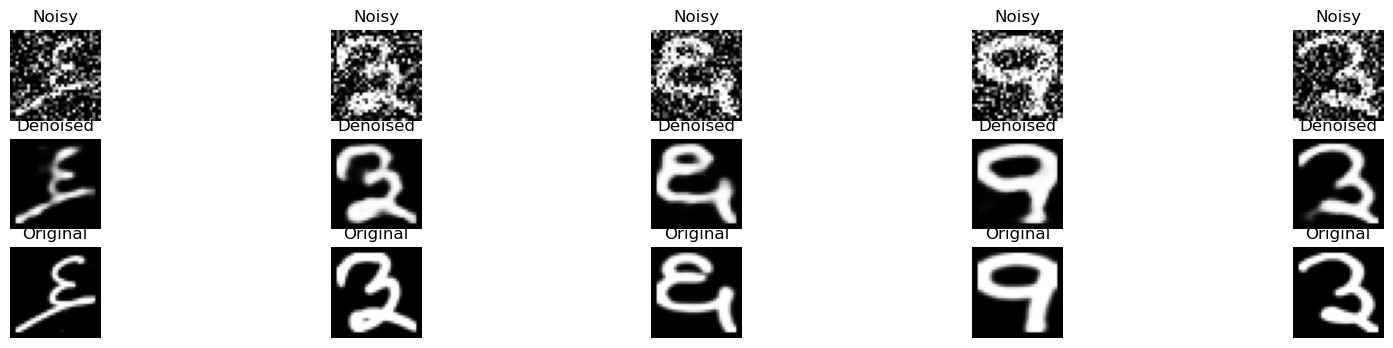

In [8]:
# Predict
decoded_imgs = autoencoder.predict(x_val_noisy)

# Display
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(32, 32), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_val[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')
plt.show()
